# AIN 214 - PA5 - 2023 on Clustering

This homework aims to deepen your understanding of clustering algorithms and introduce the concept of dimensionality reduction using Principal Component Analysis (PCA). You will use K-Means and Agglomerative Clustering, and explore the impact of PCA on these clustering techniques.



# Student Info
## Name Surname: Emirhan Utku
## Student ID:  2210765029


## Dataset

We will use the Mall Customer Segmentation Data from Kaggle. The dataset is added to the homework folder - also accessible at [here](https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python/).
 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.datasets import load_iris
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering



import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Mall_Customers.csv')

## 1. Data Cleaning

* **Objective**: Prepare your dataset for analysis.
* **Tasks**: Handle missing values, encode categorical features, handle outliers.

The steps for data cleaning may vary. I do not expect you to use a spefisific algorithm to handle outliers for example. But **show your work!**


In [3]:
#Handle missing values

columns_with_missing_values = df.columns[df.isnull().any()]

df.dropna(subset=columns_with_missing_values, inplace=True)

In [4]:
df.drop(columns='CustomerID',inplace=True)

 - Dropped the Customer ID as it doesn't offer relevant information for this assignment

In [5]:
dummies = pd.get_dummies(df['Gender'],prefix='Gender')
df = pd.concat([df,dummies],axis=1).drop(columns=['Gender'])
display(df)

,Age,Annual Income (k$),Spending Score (1-100),Gender_Female,Gender_Male
0,19,15,39,0,1
1,21,15,81,0,1
2,20,16,6,1,0
3,23,16,77,1,0
4,31,17,40,1,0
...,...,...,...,...,...
195,35,120,79,1,0
196,45,126,28,1,0
197,32,126,74,0,1
198,32,137,18,0,1


- Transforms the 'Gender' column in the DataFrame 'df' into binary dummy variables with prefixed column names, and replaces the original column with these dummy variables.

In [6]:
#Handle outliers
display(df)

def remove_outliers(column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df.loc[df[column] > upper_bound, column] = int(df[column].mean())
    df.loc[df[column] < lower_bound, column] = int(df[column].mean())
    

numeric_columns = ["Age","Annual Income (k$)","Spending Score (1-100)"]
for col in numeric_columns:
    remove_outliers(col)
    

print("\nAfter outlier handling:")
display(df)   
  


,Age,Annual Income (k$),Spending Score (1-100),Gender_Female,Gender_Male
0,19,15,39,0,1
1,21,15,81,0,1
2,20,16,6,1,0
3,23,16,77,1,0
4,31,17,40,1,0
...,...,...,...,...,...
195,35,120,79,1,0
196,45,126,28,1,0
197,32,126,74,0,1
198,32,137,18,0,1



After outlier handling:


,Age,Annual Income (k$),Spending Score (1-100),Gender_Female,Gender_Male
0,19,15,39,0,1
1,21,15,81,0,1
2,20,16,6,1,0
3,23,16,77,1,0
4,31,17,40,1,0
...,...,...,...,...,...
195,35,120,79,1,0
196,45,126,28,1,0
197,32,126,74,0,1
198,32,60,18,0,1


- "Due to the limited size of our dataset, I addressed outliers by performing mean imputation and utilized the Interquartile Range (IQR) method for outlier detection

## 2. Data Preprocessing

* **Objective**: Transform raw data into a format suitable for ML algorithms: PCA, and clustering, such as normalization.

In [7]:
#Perform data normalization

columns_to_normalize = df.columns
scaler = MinMaxScaler()
df_normalized = scaler.fit_transform(df[columns_to_normalize])


## 3. Dimensionality Reduction

### What is Dimensionality Reduction and Why is it Used?
Dimensionality reduction is the process of reducing the number of random variables under consideration by obtaining a set of principal variables. It is an attempt to reduce the complexity of the task as an attempt to remove the curse of dimensionality - also for visualization purposes.

### 3.1. Principal Component Analysis (PCA)
PCA is a technique that transforms original correlated features into new uncorrelated features (principal components) based on variance.
**Process:**
* **Linear Combinations of Features:** PCA begins by creating linear combinations of the existing features in the dataset.
* **First Principal Component:** The first principal component (PC1) is the linear combination that captures the highest variance in the dataset. Mathematically, this is the direction in which the data varies the most.
* **Subsequent Principal Components:** Each following principal component is the linear combination of features that captures the highest variance possible while being orthogonal (perpendicular) to all previously determined principal components. This ensures that each new principal component adds unique information.
* **Covariance Matrix and Eigenvectors:** The process of finding these principal components corresponds to computing the eigenvectors of the covariance matrix of the data. The covariance matrix encapsulates how each pair of variables in the dataset co-varies.
* **Eigenvalues:** The eigenvalues associated with each eigenvector (principal component) indicate the amount of variance that the principal component explains. Larger eigenvalues mean more variance explained.





### 3.2. Apply PCA
* Normalize the data
* Apply PCA to the normalized data using scikit-learn
* Visualize the data with the first two principal components (PC) as the axes. Do you see any clusters?
* Components selection: Visualize the variance explained by each PC. Then choose the number of components that explain the data sufficiently enough.

**Simply use the PCA from sklearn library**

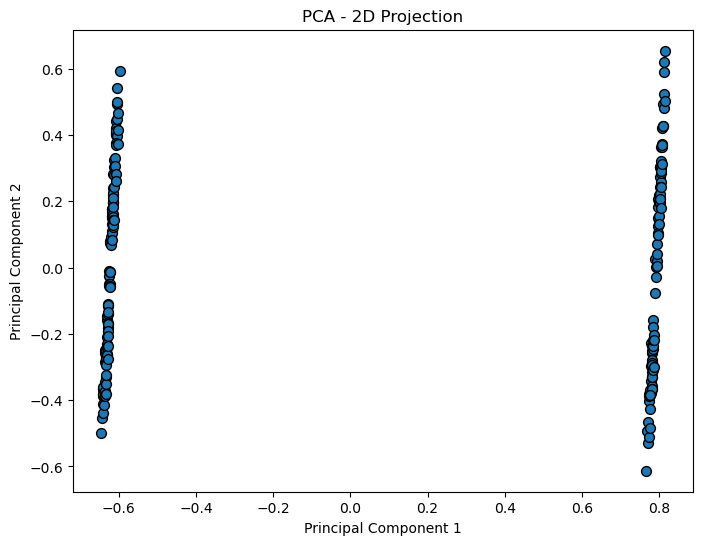

In [8]:
pca = PCA()  
X_pca = pca.fit_transform(df_normalized)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], cmap='viridis', edgecolor='k', s=50)
plt.title('PCA - 2D Projection')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

### After visualizing the data with a scatter plot after PCA, I see clearly clustering structures consisting of points close to each other on this chart.

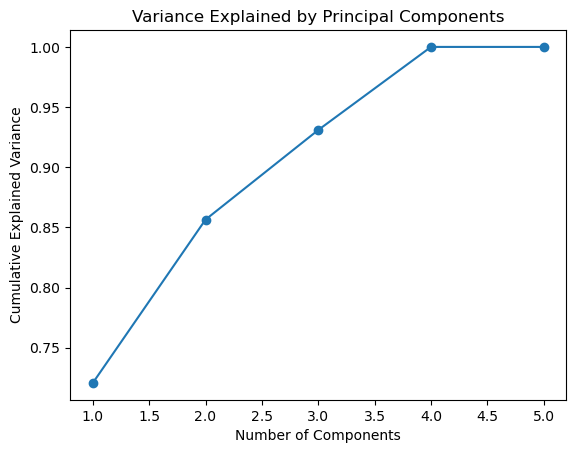

In [9]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = explained_variance_ratio.cumsum()

plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Variance Explained by Principal Components')
plt.show()

### When choosing the number of components, we generally want the Cumulative Explained Variance value to be greater than 0.95, so we should choose  4  as the number of components.

## 4. Clustering on the Original Dataset

### 4.1. K-Means Clustering on the Original Dataset

Choose the optimal k using the Elbow method. Then, visualize the resulting clusters with that k.

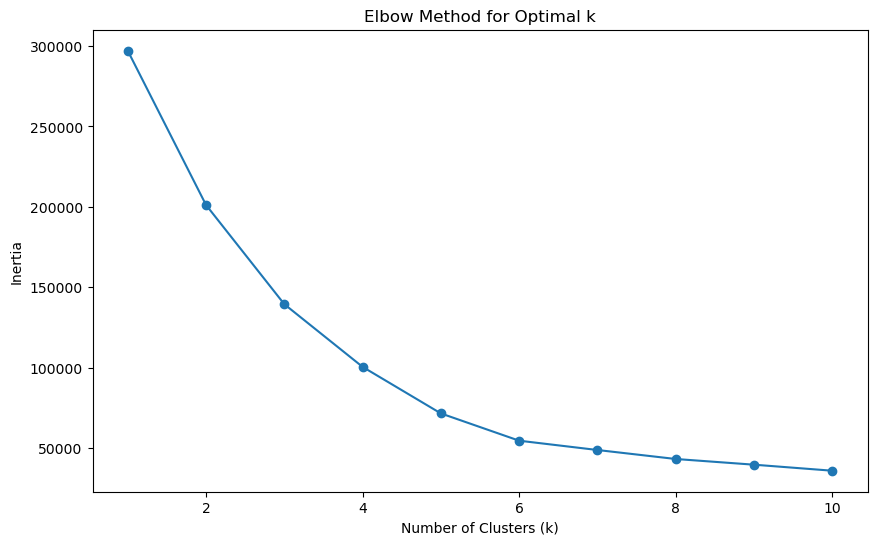

In [10]:
k_values = range(1, 11)

inertia = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df)
    inertia.append(kmeans.inertia_)


plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()


- **Look for the "elbow" point in the plot, where the inertia starts to decrease at a slower rate. This is a subjective process.**
- **The optimal k is often considered to be the point where the rate of decrease sharply changes, resembling an elbow.**
- **In the example plot, the elbow point is around k=3. Therefore, k=3 is considered the optimal number of clusters.**

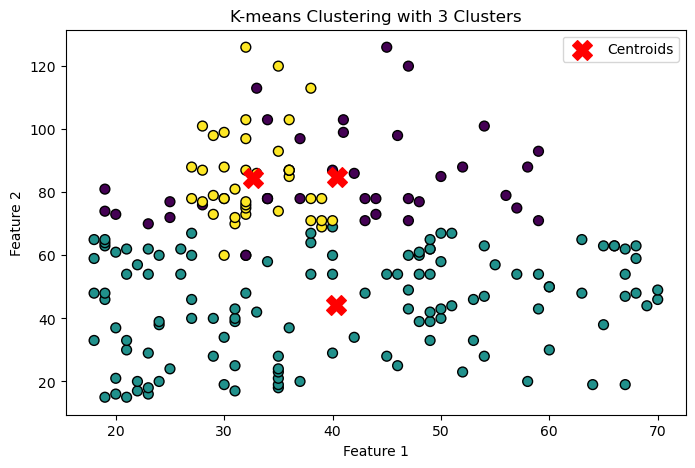

In [11]:

kmeans = KMeans(n_clusters=3, random_state=0)
two_means_clusters = kmeans.fit_predict(df)

plt.figure(figsize=(8, 5))
plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c=two_means_clusters, cmap='viridis', marker='o', edgecolor='k', s=50)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red', marker='X', label='Centroids')
plt.title('K-means Clustering with 3 Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

### 4.2. Hierarchical Agglomerative Clustering (HAC) on the Original Dataset

Apply HAC on the dataset, visualize the dendogram. Then, comment on whether the dendogram agrees with the clusters obtained by K-Means. Try with 2 different linkage methods.

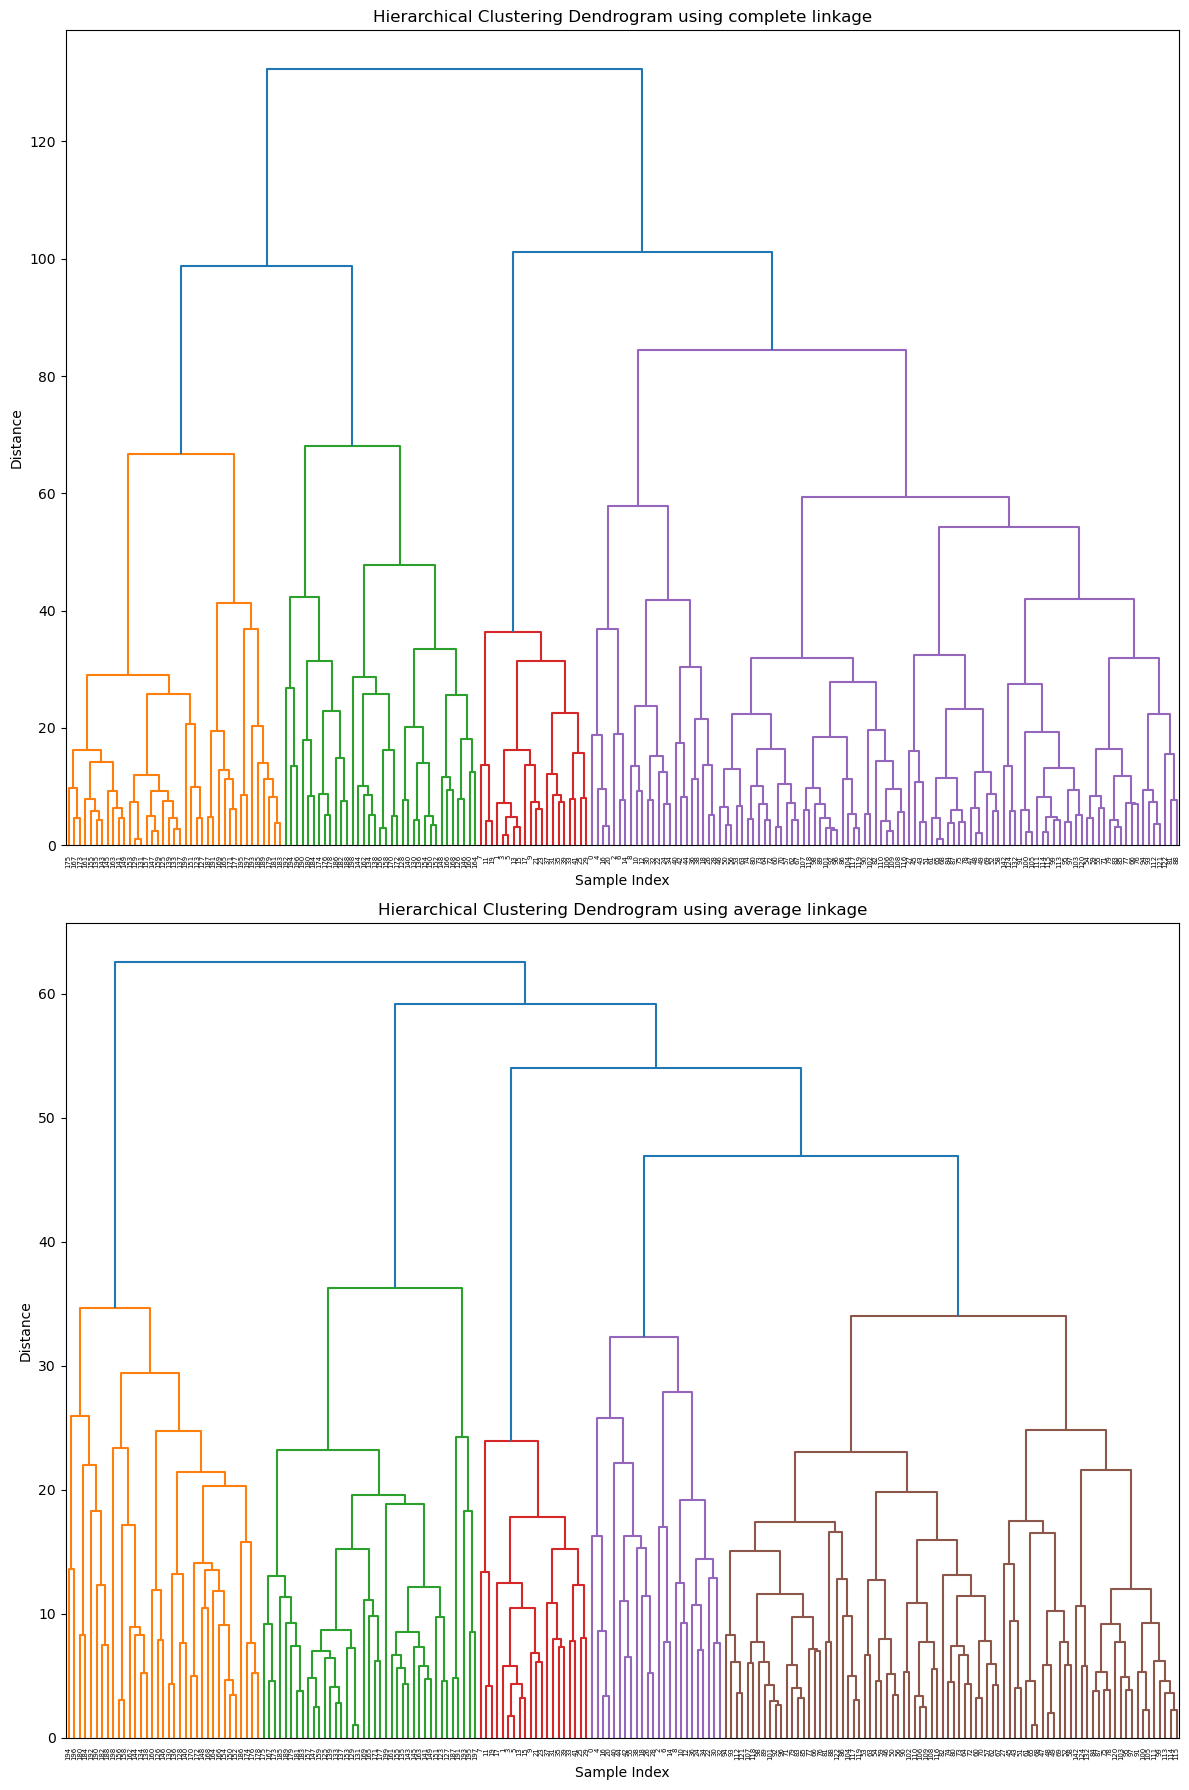

In [12]:
linkage_methods = ['complete', 'average']

fig, axes = plt.subplots(2, 1, figsize=(12, 18))

for i, method in enumerate(linkage_methods):
    Z = linkage(df, method=method)

    # Plotting the dendrogram
    axes[i].set_title(f'Hierarchical Clustering Dendrogram using {method} linkage')
    axes[i].set_xlabel('Sample Index')
    axes[i].set_ylabel('Distance')
    dendrogram(Z, ax=axes[i])

plt.tight_layout()
plt.show()

- If we choose a height cutoff value close to 55 for the average linkage, we can observe the formation of 3 clusters.

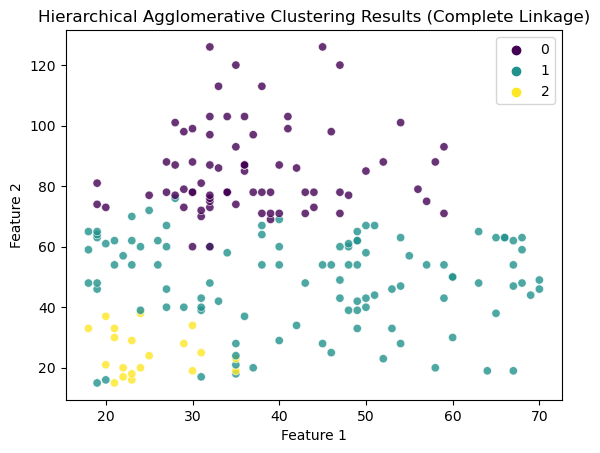

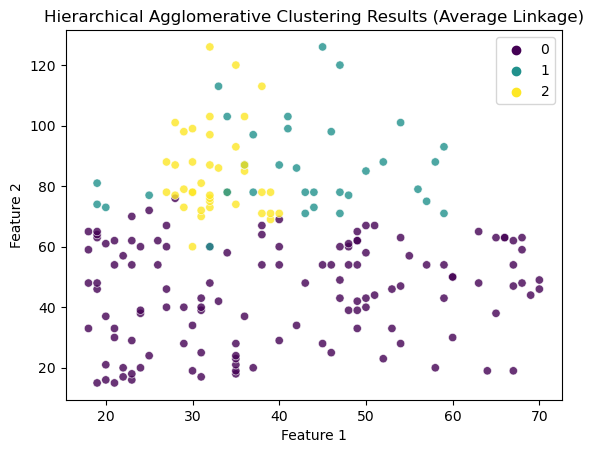

In [13]:
hac_complete = AgglomerativeClustering(n_clusters=3, linkage='complete')
clusters_hac_complete = hac_complete.fit_predict(df)

hac_average = AgglomerativeClustering(n_clusters=3, linkage='average')
clusters_hac_average =hac_average.fit_predict(df)


sns.scatterplot(x=df.iloc[:, 0], y=df.iloc[:, 1], hue=clusters_hac_complete, palette='viridis', alpha=0.8)
plt.title('Hierarchical Agglomerative Clustering Results (Complete Linkage)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

sns.scatterplot(x=df.iloc[:, 0], y=df.iloc[:, 1], hue=clusters_hac_average, palette='viridis', alpha=0.8)
plt.title('Hierarchical Agglomerative Clustering Results (Average Linkage)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

### Average linkage agrees with the clusters obtained by K-Means. For feature 2, values between 0 and 70 belong to a specific cluster, while values greater than 70 are not strictly allocated to a specific cluster.

## 5. K-means Clustering with PCA

Choose the optimal k using the Elbow method. Then, visualize the resulting clusters with that k.

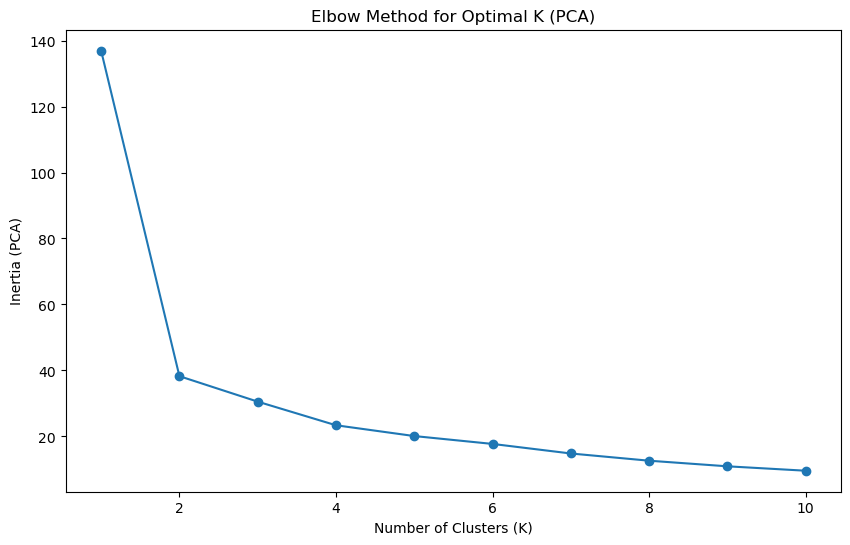

In [14]:
inertia_pca = []
k_range_pca = range(1, 11)

for k in k_range_pca:
    kmeans_pca = KMeans(n_clusters=k, random_state=42)
    kmeans_pca.fit(X_pca)
    inertia_pca.append(kmeans_pca.inertia_)


plt.figure(figsize=(10, 6))
plt.plot(k_range_pca, inertia_pca, marker='o')
plt.title('Elbow Method for Optimal K (PCA)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (PCA)')
plt.show()

- **Look for the "elbow" point in the plot, where the inertia starts to decrease at a slower rate. This is a subjective process.**
- **The optimal k is often considered to be the point where the rate of decrease sharply changes, resembling an elbow.**
- **In the example plot, the elbow point is around k=2. Therefore, k=2 is considered the optimal number of clusters.**

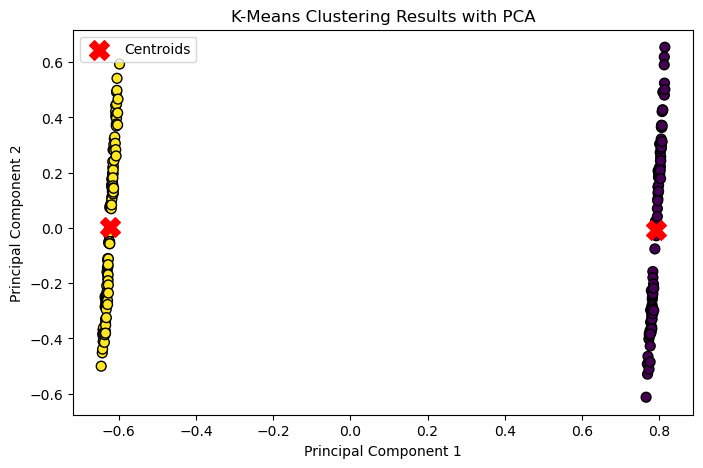

In [15]:
optimal_k_pca = 2  


kmeans_pca = KMeans(n_clusters=optimal_k_pca, random_state=42)
cluster_labels_pca = kmeans_pca.fit_predict(X_pca)


plt.figure(figsize=(8, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels_pca, cmap='viridis', marker='o', edgecolor='k', s=50)
plt.scatter(kmeans_pca.cluster_centers_[:, 0], kmeans_pca.cluster_centers_[:, 1], s=200, c='red', marker='X', label='Centroids')
plt.title('K-Means Clustering Results with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

## 6. Evaluate the Clustering Results

* Evaluate and compare the clustering results obtained in 4.1 and 5 (k means with and without PCA) using the Silhouette Coefficients.
* Which is better?

In [16]:
silhouette_score_original = silhouette_score(df, two_means_clusters, random_state=42)


silhouette_score_pca = silhouette_score(X_pca, cluster_labels_pca, random_state=42)


print(f"Silhouette Coefficient without PCA: {silhouette_score_original}")
print(f"Silhouette Coefficient with PCA: {silhouette_score_pca}")


Silhouette Coefficient without PCA: 0.37472125340533013
Silhouette Coefficient with PCA: 0.6298722635104643


#### The Silhouette Coefficient is a measure of how well-defined and separated the clusters are within a dataset. The higher the Silhouette Coefficient, the better the clustering performance.
- **Without PCA (Principal Component Analysis):**
  **The value of 0.375 indicates moderate cluster separation. The clusters are somewhat well-defined, but there is room for improvement**

- **With PCA (Principal Component Analysis):**
    **The higher value of 0.630 suggests better cluster separation when using PCA. The clusters in the reduced-dimensional space obtained through PCA are more well-defined compared to the original space.**
    
#### PCA seems to have helped in capturing meaningful patterns or dimensions in the data that contribute to more distinct clusters.

